In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn #파이토치 nn모듈 임포트
import torch.optim as optim # PyTorch optim패키지 임포트
from torch.optim import lr_scheduler # 학습률 스케쥴러 임포트
import numpy as np # 넘파이 임포트
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pip install split-folders tqdm

In [ ]:
#import splitfolders
#splitfolders.ratio('/content/drive/MyDrive/CARS', output="/content/drive/MyDrive/CARC", seed=77, ratio=(.8, 0.1, 0.1))

In [ ]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([  # 이미지 변형시키기
       transforms.Resize((224, 224)),
       transforms.RandomCrop(150),
       transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(p = 1),
        transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)), # 이미지 사이즈를 resize로 변경한다.
        #transforms.CenterCrop(200), # 이미지 중앙을 resize × resize로 자른다
        transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
        
    ]),

    'test': transforms.Compose([
        transforms.Resize((224, 224)), # 이미지 사이즈를 resize로 변경한다.
        #transforms.CenterCrop(200), # 이미지 중앙을 resize × resize로 자른다
        transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
        
    ]),


}

data_dir = '/content/drive/MyDrive/CARC' # 경로설정
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), # 설정한 경로에서 이미지를 가져오고 리사이즈에서 데이터저장
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # gpu사용불가면 cpu를 사용.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


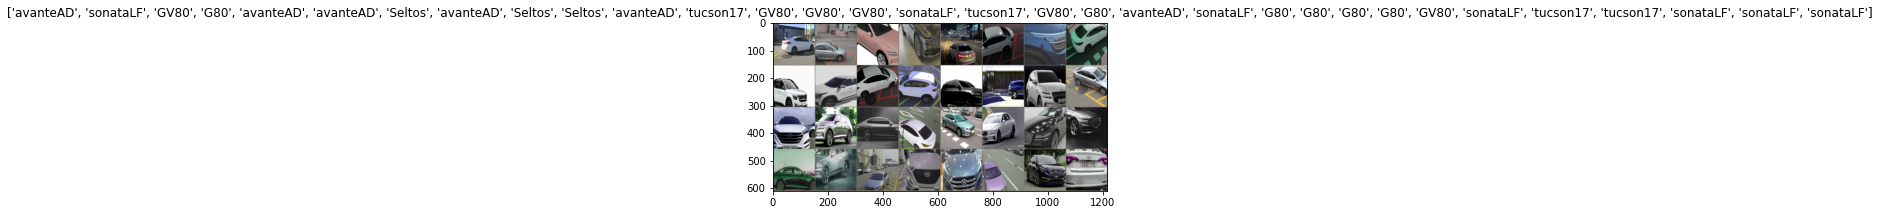

In [ ]:
def imshow(inp, title=None): # 사용할 이미지의 일부를 보여줌
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['train'])) # 학습 데이터의 배치를 얻습니다.
out = torchvision.utils.make_grid(inputs) # 배치로부터 격자 형태의 이미지를 만듭니다.

imshow(out, title=[class_names[x] for x in classes]) # 이미지 보여주기


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


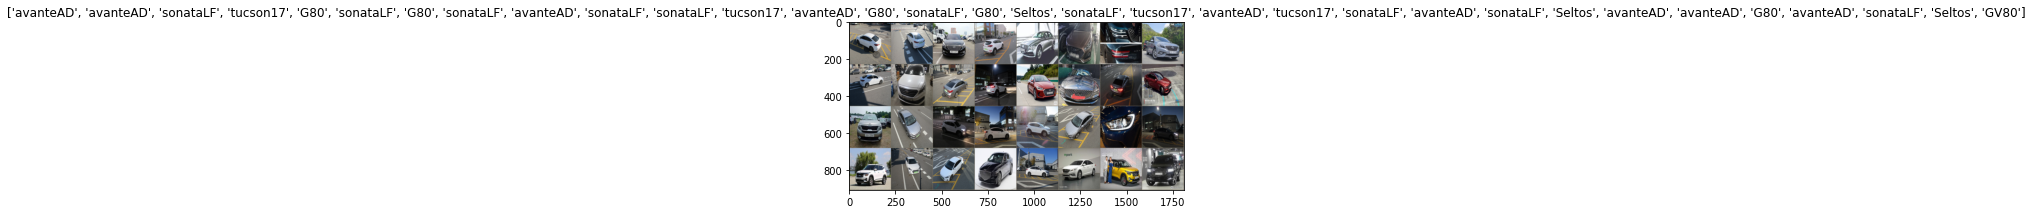

In [ ]:
def imshow(inp, title=None): # 사용할 이미지의 일부를 보여줌
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['val'])) # 학습 데이터의 배치를 얻습니다.
out = torchvision.utils.make_grid(inputs) # 배치로부터 격자 형태의 이미지를 만듭니다.

imshow(out, title=[class_names[x] for x in classes]) # 이미지 보여주기


In [ ]:
def visualize_model(model, num_images=6): # val 일부이미지에대한 예측값을 보여주는 함수
    was_training = model.training
    model.eval() # 모델을 검증모드로
    images_so_far = 0
    fig = plt.figure() #figure를 만들고 편집 할 수 있게 만들어주는 함수

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]])) # 가장 높은확률의 이름 출력
                imshow(inputs.cpu().data[j]) # 예측하려고 입력된 이미지 보여주기

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
pip install efficientnet_pytorch


  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=8030fb86136cd115afebaaa3b06ab4925ec478aca6177b4d076137a235b4a245
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dS

In [ ]:
model_name = 'efficientnet-b0'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=6)
print(model)

model_ft = model.to(device)
criterion = nn.CrossEntropyLoss() 


224
Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Con

In [ ]:
# 파인 튜닝으로 학습할 파라미터를 params_to_update 변수의 1~3에 저장한다

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 학습시킬 층의 파라미터명을 지정
#update_param_names_1 = []
update_param_names_2 = [
                        "_blocks.11._expand_conv.weight", "_blocks.11._depthwise_conv.weight", "_blocks.11._se_reduce.weight", "_blocks.11._se_reduce.bias", "_blocks.11._se_expand.weight", "_blocks.11._se_expand.bias", "_blocks.11._project_conv.weight", 
                        "_blocks.12._expand_conv.weight", "_blocks.12._depthwise_conv.weight", "_blocks.12._se_reduce.weight", "_blocks.12._se_reduce.bias", "_blocks.12._se_expand.weight", "_blocks.12._se_expand.bias", "_blocks.12._project_conv.weight", 
                        "_blocks.13._expand_conv.weight", "_blocks.13._depthwise_conv.weight", "_blocks.13._se_reduce.weight", "_blocks.13._se_reduce.bias", "_blocks.13._se_expand.weight", "_blocks.13._se_expand.bias", "_blocks.13._project_conv.weight", 
                        "_blocks.14._expand_conv.weight", "_blocks.14._depthwise_conv.weight", "_blocks.14._se_reduce.weight", "_blocks.14._se_reduce.bias", "_blocks.14._se_expand.weight", "_blocks.14._se_expand.bias", "_blocks.14._project_conv.weight", 
                        "_blocks.15._expand_conv.weight", "_blocks.15._depthwise_conv.weight", "_blocks.15._se_reduce.weight", "_blocks.15._se_reduce.bias", "_blocks.15._se_expand.weight", "_blocks.15._se_expand.bias", "_blocks.15._project_conv.weight"

                        ]

update_param_names_3 = ["_fc.weight", "_fc.bias"]

# 파라미터를 각각 리스트에 저장
for name, param in model.named_parameters():

    #if update_param_names_1[0] in name:
     #   param.requires_grad = True
      #  params_to_update_1.append(param)
       # print("params_to_update_1에 저장: ", name)

    if name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2에 저장: ", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3에 저장: ", name)

    else:
        param.requires_grad = False
        print("경사 계산없음. 학습하지 않음: ", name)


경사 계산없음. 학습하지 않음:  _conv_stem.weight
경사 계산없음. 학습하지 않음:  _bn0.weight
경사 계산없음. 학습하지 않음:  _bn0.bias
경사 계산없음. 학습하지 않음:  _blocks.0._depthwise_conv.weight
경사 계산없음. 학습하지 않음:  _blocks.0._bn1.weight
경사 계산없음. 학습하지 않음:  _blocks.0._bn1.bias
경사 계산없음. 학습하지 않음:  _blocks.0._se_reduce.weight
경사 계산없음. 학습하지 않음:  _blocks.0._se_reduce.bias
경사 계산없음. 학습하지 않음:  _blocks.0._se_expand.weight
경사 계산없음. 학습하지 않음:  _blocks.0._se_expand.bias
경사 계산없음. 학습하지 않음:  _blocks.0._project_conv.weight
경사 계산없음. 학습하지 않음:  _blocks.0._bn2.weight
경사 계산없음. 학습하지 않음:  _blocks.0._bn2.bias
경사 계산없음. 학습하지 않음:  _blocks.1._expand_conv.weight
경사 계산없음. 학습하지 않음:  _blocks.1._bn0.weight
경사 계산없음. 학습하지 않음:  _blocks.1._bn0.bias
경사 계산없음. 학습하지 않음:  _blocks.1._depthwise_conv.weight
경사 계산없음. 학습하지 않음:  _blocks.1._bn1.weight
경사 계산없음. 학습하지 않음:  _blocks.1._bn1.bias
경사 계산없음. 학습하지 않음:  _blocks.1._se_reduce.weight
경사 계산없음. 학습하지 않음:  _blocks.1._se_reduce.bias
경사 계산없음. 학습하지 않음:  _blocks.1._se_expand.weight
경사 계산없음. 학습하지 않음:  _blocks.1._se_expand.bias
경사 계산없음. 학습하

In [ ]:
# 최적화 기법 설정
optimizer = optim.SGD([ #최적화 함수 SGD사용 
    #{'params': params_to_update_1, 'lr': 1e-4}, #학습률 1e-4 #0.0001
    {'params': params_to_update_2, 'lr': 1e-4}, #학습률 5e-4
    {'params': params_to_update_3, 'lr': 1e-2} #학습률 1e-3
], momentum=0.9)


In [ ]:
'''
# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9) # stacastic gradient descent 사용 

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
'''

'\n# 모든 매개변수들이 최적화되었는지 관찰\noptimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9) # stacastic gradient descent 사용 \n\n# 7 에폭마다 0.1씩 학습률 감소\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)\n'

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
           # if phase == 'train':
            #    scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/drive/MyDrive/MODELS/CARFREEZING1_3.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer,num_epochs=100)

Epoch 0/99
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.0878 Acc: 58.7719
val Loss: 0.7971 Acc: 76.7624
==> best model saved - 0 / 76.8
Epoch 1/99
----------
train Loss: 0.7380 Acc: 71.6374
val Loss: 0.6129 Acc: 76.2402
Epoch 2/99
----------
train Loss: 0.6968 Acc: 74.1715
val Loss: 0.4913 Acc: 85.1175
==> best model saved - 2 / 85.1
Epoch 3/99
----------
train Loss: 0.6193 Acc: 77.3229
val Loss: 0.4955 Acc: 80.9399
Epoch 4/99
----------
train Loss: 0.5924 Acc: 77.7453
val Loss: 0.4593 Acc: 84.5953
Epoch 5/99
----------
train Loss: 0.6067 Acc: 77.5828
val Loss: 0.4309 Acc: 84.5953
Epoch 6/99
----------
train Loss: 0.5684 Acc: 77.9077
val Loss: 0.4366 Acc: 82.5065
Epoch 7/99
----------
train Loss: 0.5296 Acc: 80.1170
val Loss: 0.3973 Acc: 85.9008
==> best model saved - 7 / 85.9
Epoch 8/99
----------
train Loss: 0.5390 Acc: 79.8895
val Loss: 0.4123 Acc: 83.8120
Epoch 9/99
----------
train Loss: 0.5457 Acc: 79.8571
val Loss: 0.4169 Acc: 84.3342
Epoch 10/99
----------
train Loss: 0.5054 Acc: 81.2865
val Loss: 0.3912 Acc: 85.6397
E

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
for x in range(3):
  visualize_model(model_ft) # val 이미지 모델 예측값 시각화

In [ ]:
def test_visualize_model(model, num_images=6): # val 일부이미지에대한 예측값을 보여주는 함수
    was_training = model.training
    model.eval() # 모델을 검증모드로
    images_so_far = 0
    fig = plt.figure() #figure를 만들고 편집 할 수 있게 만들어주는 함수

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]])) # 가장 높은확률의 이름 출력
                imshow(inputs.cpu().data[j]) # 예측하려고 입력된 이미지 보여주기

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
    ## TEST!
  
    test_and_visualize_model(model_ft)
    


In [ ]:
L_model = '/content/drive/MyDrive/MODELS/CART2_3.pt'
MODEL = torch.load(L_model)

ㅡㅠ

In [ ]:
nb_classes = 9
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;